<a href="https://colab.research.google.com/github/LeoMx11/Skin-Cancer-Classification/blob/main/Skin_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model 1: Full Batch Gradient Descent

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [2]:
import os
from PIL import Image
import torch
import numpy as np
from torch import nn

In [3]:
print(os.listdir(path + '/data/train/benign'))

['921.jpg', '136.jpg', '1234.jpg', '39.jpg', '785.jpg', '1186.jpg', '1654.jpg', '955.jpg', '271.jpg', '1749.jpg', '1138.jpg', '1512.jpg', '1081.jpg', '426.jpg', '130.jpg', '1543.jpg', '1002.jpg', '1588.jpg', '705.jpg', '1752.jpg', '1106.jpg', '794.jpg', '1185.jpg', '390.jpg', '381.jpg', '1255.jpg', '1609.jpg', '1287.jpg', '1775.jpg', '219.jpg', '242.jpg', '262.jpg', '43.jpg', '133.jpg', '120.jpg', '613.jpg', '771.jpg', '1772.jpg', '1616.jpg', '22.jpg', '666.jpg', '1141.jpg', '223.jpg', '1699.jpg', '1453.jpg', '1626.jpg', '708.jpg', '1452.jpg', '1308.jpg', '1525.jpg', '77.jpg', '382.jpg', '1695.jpg', '521.jpg', '1129.jpg', '481.jpg', '531.jpg', '1086.jpg', '1394.jpg', '711.jpg', '745.jpg', '490.jpg', '93.jpg', '1302.jpg', '1246.jpg', '1556.jpg', '137.jpg', '702.jpg', '1425.jpg', '1060.jpg', '1572.jpg', '1210.jpg', '1644.jpg', '1732.jpg', '1477.jpg', '1421.jpg', '959.jpg', '755.jpg', '1098.jpg', '1407.jpg', '296.jpg', '1058.jpg', '1124.jpg', '1368.jpg', '1417.jpg', '1211.jpg', '1783.jpg'

In [4]:
def getImageTensor(path):
    image = np.asarray(Image.open(path).convert('RGB'))
    image_tensor = torch.tensor(image)
    return image_tensor

In [5]:
getImageTensor(path + '/data/train/benign/30.jpg')

tensor([[[ 4,  2,  3],
         [ 2,  2,  2],
         [ 5,  5,  7],
         ...,
         [29, 21, 19],
         [30, 18, 18],
         [30, 19, 17]],

        [[ 4,  2,  5],
         [ 3,  3,  3],
         [ 6,  6,  6],
         ...,
         [29, 19, 18],
         [29, 19, 18],
         [30, 19, 17]],

        [[ 5,  0,  4],
         [ 3,  5,  4],
         [11,  9, 12],
         ...,
         [29, 19, 17],
         [29, 19, 17],
         [30, 19, 17]],

        ...,

        [[35, 23, 25],
         [34, 22, 24],
         [33, 21, 25],
         ...,
         [ 6,  2,  3],
         [ 4,  0,  1],
         [ 2,  0,  1]],

        [[35, 25, 26],
         [35, 23, 25],
         [34, 22, 24],
         ...,
         [ 3,  2,  0],
         [ 4,  0,  1],
         [ 3,  2,  0]],

        [[34, 24, 23],
         [35, 23, 23],
         [34, 24, 23],
         ...,
         [ 5,  0,  4],
         [ 3,  1,  4],
         [ 3,  1,  2]]], dtype=torch.uint8)

In [6]:
benign_train = []
benign_test = []
malignant_train = []
malignant_test = []

for file in os.listdir(path + '/data/train/benign'):
    benign_train.append(getImageTensor(path + '/data/train/benign/' + file))

for file in os.listdir(path + '/data/train/malignant'):
    malignant_train.append(getImageTensor(path + '/data/train/malignant/' + file))

for file in os.listdir(path + '/data/test/benign'):
    benign_test.append(getImageTensor(path + '/data/test/benign/' + file))

for file in os.listdir(path + '/data/test/malignant'):
    malignant_test.append(getImageTensor(path + '/data/test/malignant/' + file))


In [7]:
benign_test = torch.stack(benign_test)
benign_train = torch.stack(benign_train)
malignant_test = torch.stack(malignant_test)
malignant_train = torch.stack(malignant_train)

In [8]:
benign_test.shape, benign_train.shape, malignant_test.shape, malignant_train.shape

(torch.Size([360, 224, 224, 3]),
 torch.Size([1440, 224, 224, 3]),
 torch.Size([300, 224, 224, 3]),
 torch.Size([1197, 224, 224, 3]))

In [9]:
y_benign_test = np.zeros(len(benign_test))
y_benign_train = np.zeros(len(benign_train))
y_malignant_test = np.ones(len(malignant_test))
y_malignant_train = np.ones(len(malignant_train))

In [10]:
X_train = torch.cat((benign_train, malignant_train))
X_test = torch.cat((benign_test, malignant_test))

y_train = torch.tensor(np.concatenate((y_benign_train, y_malignant_train)))
y_test = torch.tensor(np.concatenate((y_benign_test, y_malignant_test)))

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2637, 224, 224, 3]),
 torch.Size([660, 224, 224, 3]),
 torch.Size([2637]),
 torch.Size([660]))

In [12]:
X_train = X_train.transpose(1, 3)
X_test = X_test.transpose(1, 3)

In [13]:
from torch.utils.data import dataloader
import matplotlib.pyplot as plt

In [14]:
class SkinCancerClassifierV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_stack = nn.Sequential(
      nn.Conv2d(3, 1, 3, stride = 2),
      nn.MaxPool2d(2,2),
      nn.Flatten(),
      nn.Linear(3025, 10),
      nn.Linear(10, 1)
      )

  def forward(self, x):
    return self.layer_stack(x)



In [15]:
my_model = SkinCancerClassifierV1()
my_model.state_dict()

OrderedDict([('layer_stack.0.weight',
              tensor([[[[ 0.0013, -0.0351,  0.1624],
                        [-0.0165, -0.1154,  0.0873],
                        [-0.1870, -0.1531, -0.1541]],
              
                       [[ 0.1855,  0.1681,  0.1232],
                        [-0.0077, -0.0415,  0.1009],
                        [ 0.1343, -0.0319,  0.1514]],
              
                       [[-0.0356,  0.1141, -0.1280],
                        [-0.1539, -0.1028,  0.0022],
                        [ 0.0342,  0.0281, -0.0527]]]])),
             ('layer_stack.0.bias', tensor([0.0997])),
             ('layer_stack.3.weight',
              tensor([[-0.0065, -0.0095,  0.0095,  ...,  0.0112, -0.0144, -0.0037],
                      [-0.0021,  0.0100, -0.0040,  ..., -0.0174,  0.0071, -0.0150],
                      [-0.0008,  0.0125,  0.0032,  ...,  0.0019, -0.0021,  0.0008],
                      ...,
                      [ 0.0093, -0.0049,  0.0040,  ..., -0.0170, -0.0061, -0

In [16]:
optimizer = torch.optim.Adam(my_model.parameters(), lr = 0.005)
loss_fn = nn.BCEWithLogitsLoss()

In [17]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

Epoch: 0 | Loss: 0.88669 | Acc: 66.89% | Test Loss: 213.60646057128906 | Test Accuracy: 45.30%
Epoch: 1 | Loss: 217.98633 | Acc: 45.35% | Test Loss: 28.933818817138672 | Test Accuracy: 58.48%
Epoch: 2 | Loss: 31.83152 | Acc: 58.51% | Test Loss: 34.206031799316406 | Test Accuracy: 69.39%
Epoch: 3 | Loss: 32.07224 | Acc: 71.03% | Test Loss: 89.5461196899414 | Test Accuracy: 71.67%
Epoch: 4 | Loss: 79.16505 | Acc: 72.51% | Test Loss: 113.42914581298828 | Test Accuracy: 70.15%
Epoch: 5 | Loss: 101.09724 | Acc: 69.81% | Test Loss: 80.09732818603516 | Test Accuracy: 74.85%
Epoch: 6 | Loss: 70.61473 | Acc: 74.29% | Test Loss: 49.78620529174805 | Test Accuracy: 70.15%
Epoch: 7 | Loss: 46.59999 | Acc: 71.56% | Test Loss: 50.9090690612793 | Test Accuracy: 64.39%
Epoch: 8 | Loss: 56.40030 | Acc: 65.91% | Test Loss: 57.16352844238281 | Test Accuracy: 63.79%
Epoch: 9 | Loss: 63.81982 | Acc: 63.44% | Test Loss: 44.221317291259766 | Test Accuracy: 62.88%
Epoch: 10 | Loss: 49.43269 | Acc: 64.20% | Tes

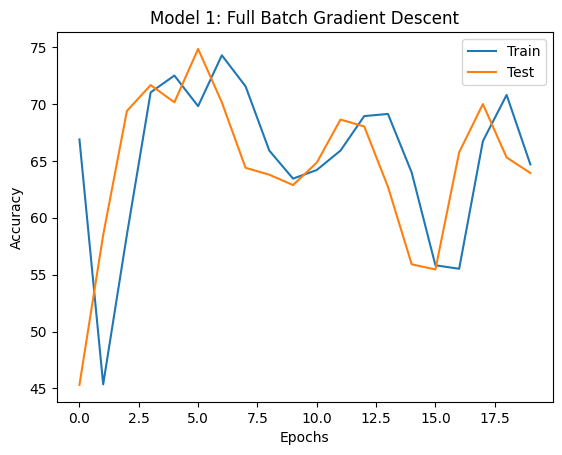

In [18]:
train_acc_list = []
test_acc_list = []

epochs = 20

for epoch in range(epochs):

  my_model.train()

  y_logits = my_model(X_train.float()).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train.float())
  acc = accuracy(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  my_model.eval()
  with torch.inference_mode():
    test_logits = my_model(X_test.float()).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test.float())
    test_acc = accuracy(y_test, test_pred)

  if epoch % 1 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:} | Test Accuracy: {test_acc:.2f}%")

  train_acc_list.append(acc)
  test_acc_list.append(test_acc)

epoch = list(range(epochs))

plt.plot(epoch, train_acc_list, label = 'Train')
plt.plot(epoch, test_acc_list, label = 'Test')
plt.title('Model 1: Full Batch Gradient Descent')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model 2: Mini-Batch Gradient Descent

In [19]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

In [20]:
train_dataloader = dataloader.DataLoader(train, batch_size = 32, shuffle = True)
test_dataloader = dataloader.DataLoader(test, batch_size = 32, shuffle = True)

In [21]:
class SkinCancerClassifierV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_stack = nn.Sequential(
      nn.Conv2d(3, 4, 3, stride = 2),
      nn.MaxPool2d(2,2),
      nn.Conv2d(4, 4, 3, stride = 1),
      nn.Conv2d(4, 4, 3, stride = 2),
      nn.MaxPool2d(2,2),
      nn.Conv2d(4,4,3,stride = 2),
      nn.Flatten(),
      nn.Linear(144, 8),
      nn.Linear(8, 1)
      )

  def forward(self, x):
    return self.layer_stack(x)


In [22]:
my_model2 = SkinCancerClassifierV2()
optimizer = torch.optim.Adam(my_model2.parameters(), lr = 0.002)
loss_fn = nn.BCEWithLogitsLoss()


Epoch: 0 | Loss: 55.08660 | Acc: 63.75% | Test Loss: 10.88489 | Test Accuracy: 73.12%
Epoch: 1 | Loss: 45.25608 | Acc: 70.86% | Test Loss: 11.13521 | Test Accuracy: 76.01%
Epoch: 2 | Loss: 43.27389 | Acc: 73.99% | Test Loss: 9.15259 | Test Accuracy: 79.29%
Epoch: 3 | Loss: 39.83274 | Acc: 77.11% | Test Loss: 9.64017 | Test Accuracy: 75.83%
Epoch: 4 | Loss: 35.29393 | Acc: 79.88% | Test Loss: 8.69949 | Test Accuracy: 80.98%
Epoch: 5 | Loss: 36.43545 | Acc: 80.18% | Test Loss: 8.51750 | Test Accuracy: 82.95%
Epoch: 6 | Loss: 33.53435 | Acc: 81.86% | Test Loss: 8.61998 | Test Accuracy: 81.34%
Epoch: 7 | Loss: 33.60542 | Acc: 81.72% | Test Loss: 8.32277 | Test Accuracy: 81.07%
Epoch: 8 | Loss: 32.32031 | Acc: 82.20% | Test Loss: 9.05136 | Test Accuracy: 81.13%
Epoch: 9 | Loss: 33.34212 | Acc: 81.67% | Test Loss: 8.58217 | Test Accuracy: 80.77%
Epoch: 10 | Loss: 30.63740 | Acc: 83.93% | Test Loss: 9.31581 | Test Accuracy: 80.92%
Epoch: 11 | Loss: 30.23486 | Acc: 83.36% | Test Loss: 8.62261 

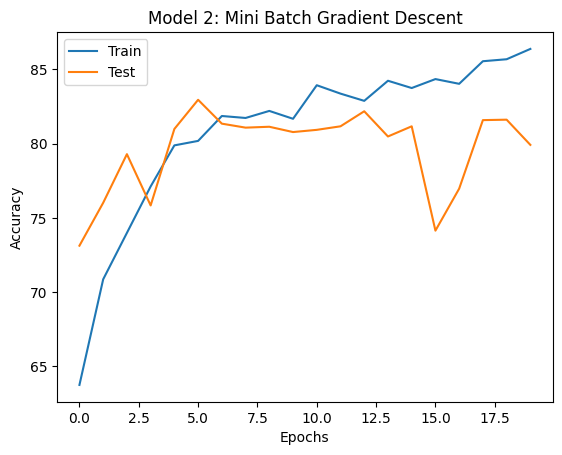

In [23]:

train_acc_list = []
test_acc_list = []

epochs = 20

for epoch in range(epochs):

  train_loss = 0
  train_acc = 0

  for X_train, y_train in train_dataloader:
    my_model2.train()

    y_logits = my_model2(X_train.float()).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    train_loss += loss
    acc = accuracy(y_train, y_pred)
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_acc /= len(train_dataloader)
  train_acc_list.append(train_acc)

  ttl_test_loss = 0
  ttl_test_acc = 0

  my_model2.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      test_logits = my_model2(X_test.float()).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss = loss_fn(test_logits, y_test.float())
      ttl_test_loss += test_loss
      test_acc = accuracy(y_test, test_pred)
      ttl_test_acc += test_acc

  ttl_test_acc /= len(test_dataloader)

  test_acc_list.append(ttl_test_acc)

  if epoch % 1 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f} | Acc: {train_acc:.2f}% | Test Loss: {ttl_test_loss:.5f} | Test Accuracy: {ttl_test_acc:.2f}%")

epoch = list(range(epochs))

plt.plot(epoch, train_acc_list, label = 'Train')
plt.plot(epoch, test_acc_list, label = 'Test')
plt.title('Model 2: Mini Batch Gradient Descent')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
